# Loan Approval Classification — Notebook

Ce notebook effectue une Analyse Exploratoire des Données (Exploratory Data Analysis, EDA), le prétraitement, la sélection des features et propose différents modèles de classification des données.

## Contexte et objectifs

### Contexte

Ce notebook a pour but d'explorer un jeu de données de demandes de prêt, de préparer les données et d'entraîner des modèles de classification (Logistic Regression) pour prédire si un prêt est accordé (`loan_status`).

Étapes réalisées dans ce document :
- Chargement et vérification rapide des données
- Analyse exploratoire (EDA) des variables
- Rééquilibrage de la target (undersampling des classes majoritaires)
- Prétraitement (imputation, standardisation, encodage) via une pipeline
- Sélection simple de features (corrélation)
- Entraînement de pipeline avec GridSearchCV pour les différents modèles
- Évaluation et sauvegarde du modèle

### Objectifs

Les modèles de classification peuvent être évalués suivant plusieurs métriques. Les plus connues d'entre elles sont la précision et le rappel (precision and recall). Le F1-score est une combinaison des deux tel que :

$$F1 = \frac{2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}}$$


$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

Où :
- **Precision** = $\frac{TP}{TP + FP}$ (proportion de prédictions positives correctes)
- **Recall** = $\frac{TP}{TP + FN}$ (proportion de vrais positifs détectés)
- TP = True Positives, FP = False Positives, FN = False Negatives

Le F1-score est la moyenne harmonique de la précision et du rappel, et atteint sa meilleure valeur à 1 (perfection) et sa pire à 0.


##### Pourquoi utilise-t-on le F1 score dans notre cas ?

Pour la banque, le plus important est une garantie de remboursement du crédit accordé. Il faut donc un être strict sur l'accord de celui-ci. On doit donc avoir un recall élevé.

En revanche, d'un point de vue morale, pour des questions d'attractivité de clientelle, la banque se doit aussi d'accorder des prêts.

On doit donc avoir un équilibre entre le recall et la précision : les deux sont importants et doivent afficher des scores élevés.


#### Objectif de F1 score

Qualitativement, on peut considérer notre modèle comme intéressant si le F1 est supérieur à 0.90, score pour lequel les recall et precision sont tous les deux hauts, garantissant à la fois une sécurité d'emprunt et une facilité d'acès à celui-ci.

$$F1 > 0.90$$

### Dépendances et kernel

Les bibliothèques importées nécessaires pour l'EDA, le prétraitement et l'entraînement.

- pandas / numpy : manipulation de données
- matplotlib : visualisations simples
- scikit-learn : pipelines, prétraitement, modèles, validation croisée
- joblib : gestion des sauvegardes locales du modèle

Les bibliothèques sont téléchargées en cas d'échec d'importation.

In [11]:
# Imports essentiels
try:
    import pandas
    import matplotlib
    import sklearn
    import joblib
except ImportError:
    ! pip install pandas matplotlib scikit-learn joblib

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


#Pour avoir les graphiques directement dans le notebook
%matplotlib inline

### Chargement des données

Cette cellule charge le fichier CSV. Vérifiez le chemin `DATA_PATH`. Après le chargement, on affiche la dimension globale (`df.shape`) et un aperçu (`df.head()`). Si le fichier n'est pas trouvé, la cellule lève une erreur pour vous alerter.

In [12]:

# Obtenir le chemin du notebook
notebook_path = os.path.abspath('')
print(f"Répertoire actuel : {notebook_path}")

# Se placer dans le répertoire du notebook
os.chdir(notebook_path)
DATA_PATH = os.path.join(os.getcwd(),'loan_data.csv')
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'Fichier introuvable: {DATA_PATH}')
df = pd.read_csv(DATA_PATH)
print('Dimensions:', df.shape)
df.head()

Répertoire actuel : /Users/amauryjanin/Library/Mobile Documents/com~apple~CloudDocs/Documents/IMT atlantique/TAF 2A/IA UE D/Projet AAA
Dimensions: (45000, 14)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### Inspection rapide des types et des valeurs manquantes

Cette cellule :
- affiche le résumé `df.info()` (types et valeurs non-null)
- compte les valeurs manquantes par colonne
- convertit `person_age` en entier si présent (attention : perte d'infos si valeurs non-integers)
- construit deux listes `cat_cols` et `num_cols` basées sur le dtype (utile pour l'EDA et la construction de transformers)

In [13]:
# Aperçu rapide et types
display(df.info())
print('\nValeurs manquantes par colonne:\n', df.isnull().sum())
# convertir person_age si présent
if 'person_age' in df.columns:
    # On cast en int pour éviter des types float si tout est entier en pratique
    df['person_age'] = df['person_age'].astype(int)

# Détection simple des colonnes catégorielles vs numériques (basée sur dtype)
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
num_cols = [c for c in df.columns if c not in cat_cols]
print('Colonnes catégorielles:', cat_cols)
print('Colonnes numériques:', num_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

None


Valeurs manquantes par colonne:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64
Colonnes catégorielles: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Colonnes numériques: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


### EDA : distributions et visualisations simples

But : comprendre la distribution des catégories, repérer des déséquilibres évidents, et observer la distribution des variables numériques (skewness, valeurs extrêmes).

- Pour les colonnes catégorielles, on trace un diagramme en barres des effectifs.
- Pour les colonnes numériques, on affiche des histogrammes.
- On affiche aussi la distribution de la target `loan_status` (pie chart) pour voir le déséquilibre initial.


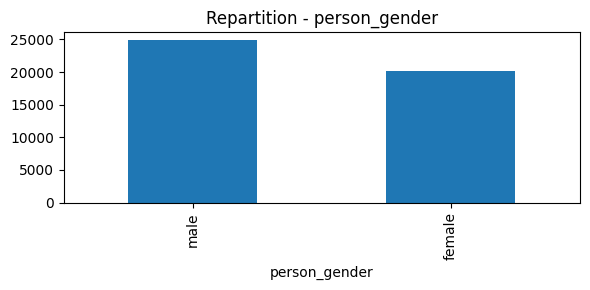

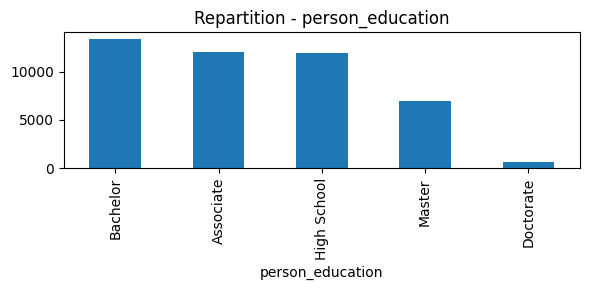

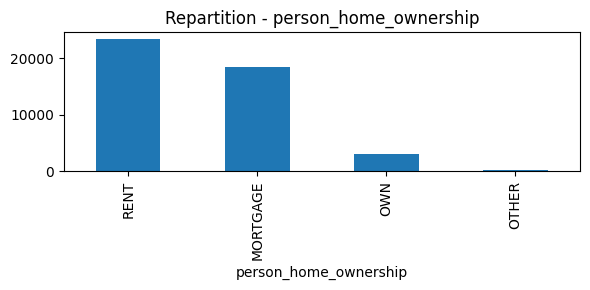

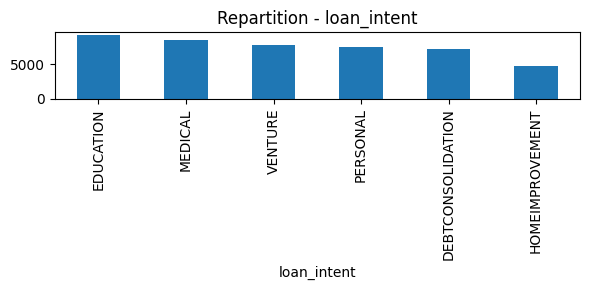

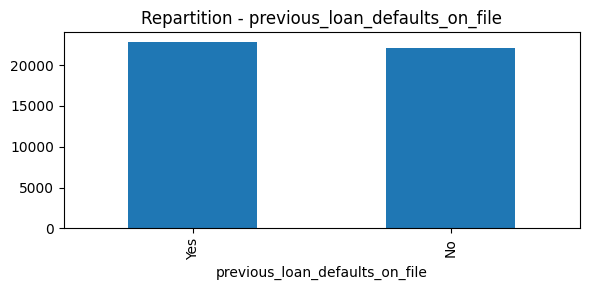

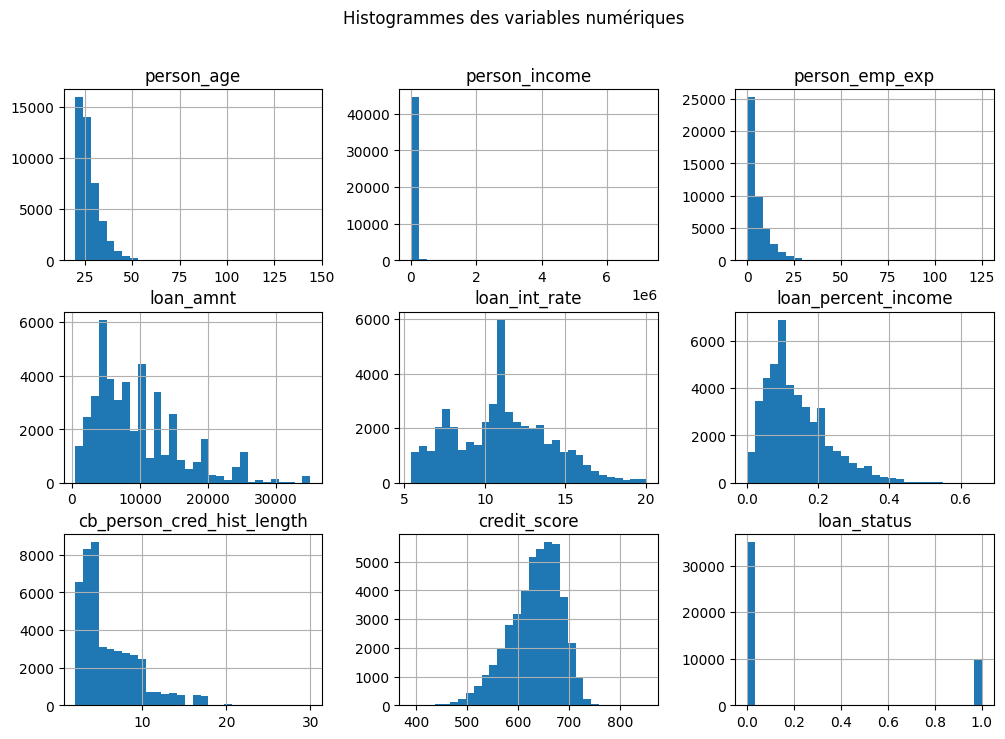

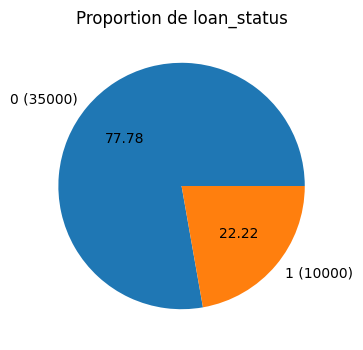

In [14]:
# EDA simple: distributions des catégorielles et des numériques
for c in cat_cols:
    plt.figure(figsize=(6,3))
    # value_counts() montre les modalités et leurs effectifs
    df[c].value_counts().plot(kind='bar', title=f'Repartition - {c}')
    plt.xlabel(c)
    plt.tight_layout()
    plt.show()

if num_cols:
    # histogrammes groupés pour repérer la forme des distributions
    df[num_cols].hist(bins=30, figsize=(12,8))
    plt.suptitle('Histogrammes des variables numériques')
    plt.show()

# Distribution de la target
if 'loan_status' in df.columns:
    counts = df['loan_status'].value_counts()
    plt.figure(figsize=(4,4))
    plt.pie(counts, labels=[str(i) + ' (' + str(n) + ')' for i,n in zip(counts.index, counts)], autopct='%.2f')
    plt.title('Proportion de loan_status')
    plt.show()


## Études des corrélations potentiels

Nous pouvons supposer que certains groupes sociaux sont plus enclins à avoir bénéficier d'accord pour un emprunt.

Par exemple, certains facteurs comme l'éducation, le montant emprunté, le montant par rapport au salaire, le score crédit de la personne peuvent directement avoir une influence sur l'emprunt.

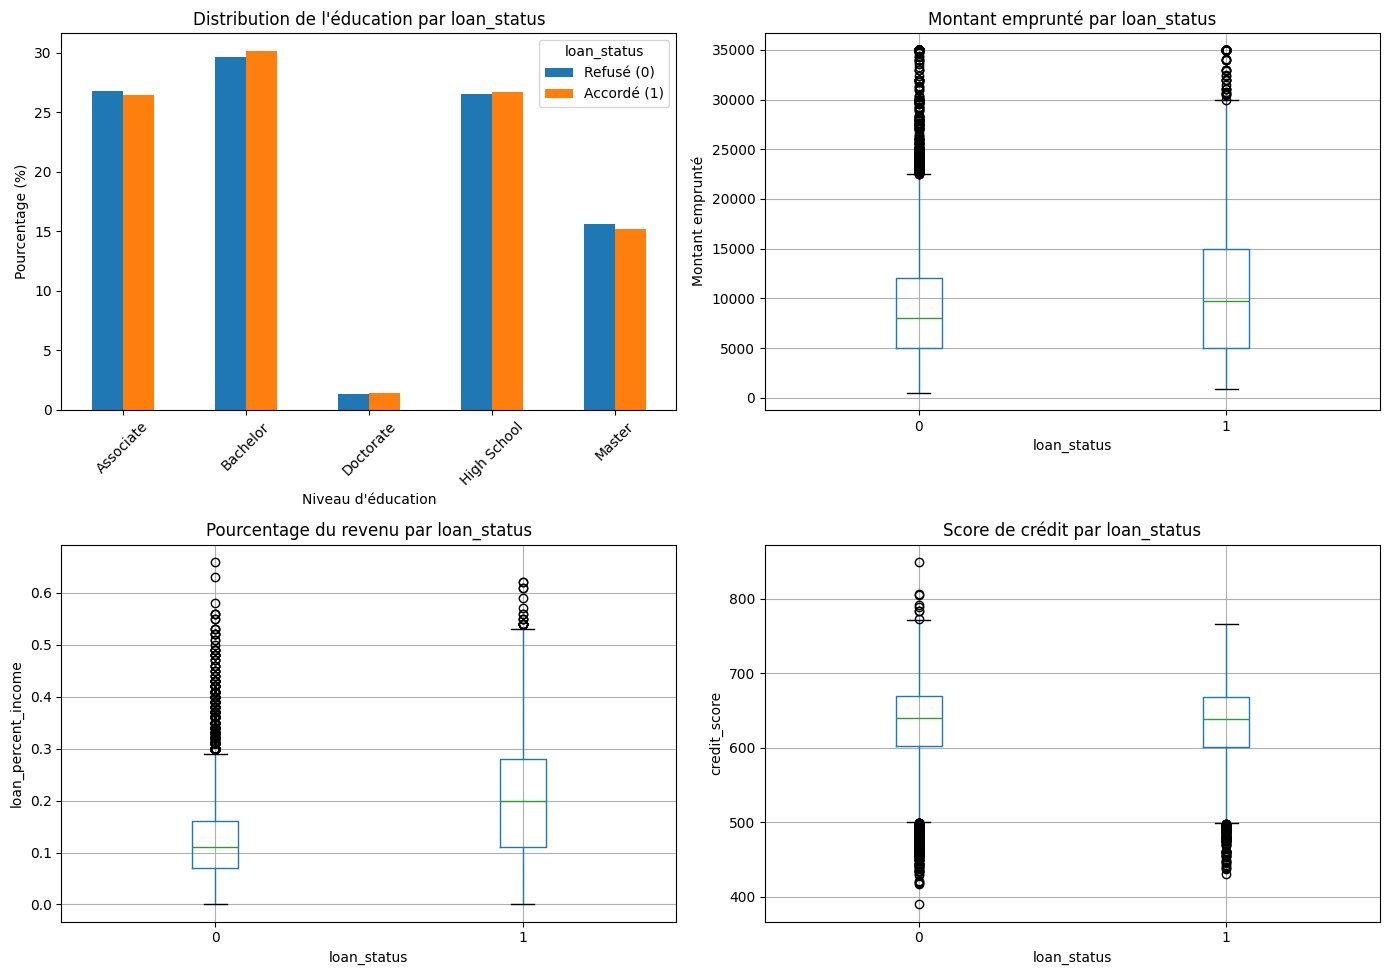

In [15]:
# Analyse de la corrélation entre loan_status et différentes variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Éducation vs loan_status
ax1 = axes[0, 0]
education_status = pd.crosstab(df['loan_status'], df['person_education'], normalize='index') * 100
education_status.T.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution de l\'éducation par loan_status')
ax1.set_xlabel('Niveau d\'éducation')
ax1.set_ylabel('Pourcentage (%)')
ax1.legend(title='loan_status', labels=['Refusé (0)', 'Accordé (1)'])
ax1.tick_params(axis='x', rotation=45)

# 2. Montant emprunté vs loan_status
ax2 = axes[0, 1]
df.boxplot(column='loan_amnt', by='loan_status', ax=ax2)
ax2.set_title('Montant emprunté par loan_status')
ax2.set_xlabel('loan_status')
ax2.set_ylabel('Montant emprunté')
ax2.get_figure().suptitle('')

# 3. Pourcentage du revenu vs loan_status
ax3 = axes[1, 0]
df.boxplot(column='loan_percent_income', by='loan_status', ax=ax3)
ax3.set_title('Pourcentage du revenu par loan_status')
ax3.set_xlabel('loan_status')
ax3.set_ylabel('loan_percent_income')
ax3.get_figure().suptitle('')

# 4. Score de crédit vs loan_status
ax4 = axes[1, 1]
df.boxplot(column='credit_score', by='loan_status', ax=ax4)
ax4.set_title('Score de crédit par loan_status')
ax4.set_xlabel('loan_status')
ax4.set_ylabel('credit_score')
ax4.get_figure().suptitle('')

plt.tight_layout()
plt.show()

Pas vraiment de corrélation...

### Rééquilibrage de la target — pourquoi l'undersampling ?

Ici, nous choisissons d'équilibrer la target `loan_status` par undersampling des classes majoritaires (réduction du nombre d'exemples des classes abondantes) afin d'obtenir des classes approximativement équilibrées.

Points importants :
- L'undersampling évite d'ajouter des exemples synthétiques mais réduit la taille totale du jeu de données.
- Si la classe minoritaire est très petite, l'undersampling peut trop appauvrir l'entraînement.
- Alternative : l'upsampling, SMOTE, ou l'utilisation de `class_weight='balanced'` dans les modèles. On ne l'utilisera pas ici

Exécutez ensuite la cellule qui suit (qui réalise l'undersampling) pour appliquer le rééquilibrage au DataFrame `df`.

In [16]:
# Rééquilibrage de la target `loan_status` à ~50/50 via undersampling (suppression d'exemples des classes majoritaires)

print('Distribution avant (counts):')
print(df['loan_status'].value_counts(dropna=False))

counts = df['loan_status'].value_counts()
min_n = counts.min()
parts = []
for cls, n in counts.items():
    subset = df[df['loan_status'] == cls]
    if n > min_n:
        # Sous-échantillonnage de la classe majoritaire jusqu'à min_n (sans remplacement)
        subset = subset.sample(n=min_n, replace=False, random_state=42)
    parts.append(subset)
df = pd.concat(parts, axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
print('Distribution après (équilibrée):')
print(df['loan_status'].value_counts())


Distribution avant (counts):
loan_status
0    35000
1    10000
Name: count, dtype: int64
Distribution après (équilibrée):
loan_status
1    10000
0    10000
Name: count, dtype: int64


### Après l'undersampling — remarques et vérifications

Cette cellule réalise l'undersampling effectif et remplace `df` par la version sous-échantillonnée.

On vérifie :
- la distribution imprimée (`value_counts`) pour s'assurer d'un bon rééquilibrage ;
- la taille totale du DataFrame (ex. `df.shape`) : elle diminuera si l'undersampling a retiré des exemples ;
- si vous souhaitez conserver `df` non modifié pour des comparaisons, faites une copie avant (`df_original = df.copy()`).

La cellule suivante construit `X` et `y` à partir de `df` (donc utilisera les données rééquilibrées).

In [17]:
# Prétraitement général: imputation/scale/OHE via ColumnTransformer
# construire X et y en incluant les colonnes clean
cols_keep = [c for c in df.columns if c != 'loan_status']
X = df[cols_keep].copy()
y = df['loan_status'].copy()


# Séparation des données numériques et catégorielles
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]
print('num_cols:', num_cols)
print('cat_cols:', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_cols), ('cat', categorical_transformer, cat_cols)])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

num_cols: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']
cat_cols: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Train/Test shapes: (16000, 13) (4000, 13)


## Modélisation pour Logisitic Regression : pipeline + GridSearchCV

But : construire un pipeline complet (préprocesseur + classifieur) et rechercher le meilleur hyperparamètre `C` pour la Logistic Regression via GridSearchCV.

- `GridSearchCV` est ici limité (recherche sur 4 valeurs de `C`) pour rester rapide ; étendez la grille si nécessaire.

Après entraînement, on récupère le meilleur estimateur et on prédit sur l'ensemble test pour obtenir les métriques affichées ensuite.

In [ ]:
# Modèle: pipeline simple avec preprocessor (sur toutes features) + LogisticRegression
pipe = Pipeline([('preprocessor', preprocessor), 
                 ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
param_grid = {'clf__C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
best = gs.best_estimator_

# évaluer sur test
y_pred = best.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))

Best params: {'clf__C': 100.0}
Test accuracy: 0.87275

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      2000
           1       0.85      0.91      0.88      2000

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



### Évaluation : métriques et matrice de confusion

- On affiche la précision, le rapport de classification (precision, recall, f1) et la matrice de confusion.
- La matrice de confusion montre les faux positifs / faux négatifs — utiles pour comprendre les erreurs du modèle.
- En contexte d'octroi de prêt, préférez souvent optimiser le recall sur la classe « prêt accordé » ou « refusé » selon le coût des erreurs.

Ensuite, une cellule trace la matrice de confusion (matplotlib).

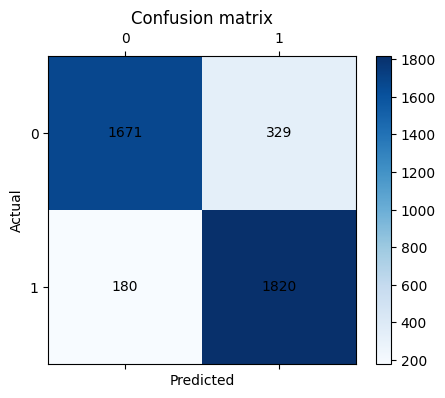

In [19]:
# Matrice de confusion (matplotlib)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm, cmap='Blues')
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels = np.unique(y_test)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([str(l) for l in labels])
ax.set_yticklabels([str(l) for l in labels])
fig.colorbar(cax)
plt.title('Confusion matrix')
plt.show()

In [ ]:
# Sauvegarder le meilleur modèle
joblib.dump(best, 'logistic_regression_basic_model.joblib')
print('Modèle sauvegardé: logistic_regression_basic_model.joblib')

# Conclusion rapide
print('\nTerminé — consultez les cellules précédentes pour les métriques et la matrice de confusion.')

## Modélisation pour Random Forest : preprocessing et gridsearch

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec RandomForest
pipe_rf = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# GridSearch pour RandomForest
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print('Best params:', gs_rf.best_params_)
best_rf = gs_rf.best_estimator_

# Évaluation sur test
y_pred_rf = best_rf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_rf))
print('\nClassification report:\n', classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Test accuracy: 0.89925

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.90      2000
           1       0.88      0.92      0.90      2000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



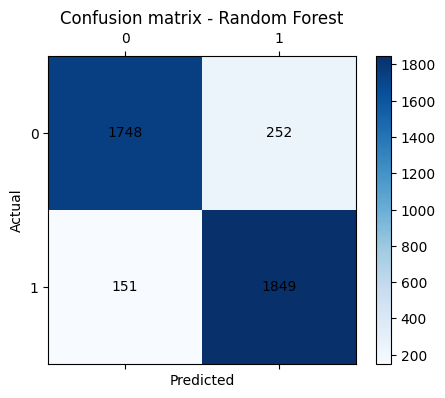

In [22]:
# Matrice de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_rf, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_rf):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_rf = np.unique(y_test)
ax.set_xticks(range(len(labels_rf)))
ax.set_yticks(range(len(labels_rf)))
ax.set_xticklabels([str(l) for l in labels_rf])
ax.set_yticklabels([str(l) for l in labels_rf])
fig.colorbar(cax)
plt.title('Confusion matrix - Random Forest')
plt.show()

In [ ]:
# Sauvegarder le meilleur modèle Random Forest
joblib.dump(best_rf, 'random_forest_model.joblib')
print('Modèle Random Forest sauvegardé: random_forest_model.joblib')

On observe que le recall pour l'approbation est meilleur que l'accuracy.

## Pipeline avec XGBoost

In [2]:
from xgboost import XGBClassifier

# Pipeline avec XGBoost
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor), 
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# GridSearch pour XGBoost
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1.0]
}

gs_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print('Best params:', gs_xgb.best_params_)
best_xgb = gs_xgb.best_estimator_

# Évaluation sur test
y_pred_xgb = best_xgb.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_xgb))
print('\nClassification report:\n', classification_report(y_test, y_pred_xgb))

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: '@rpath/libomp.dylib'\n  Referenced from: '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib'\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]


In [ ]:
# Matrice de confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(5,4))
cax = ax.matshow(cm_xgb, cmap='Blues')
for (i, j), val in np.ndenumerate(cm_xgb):
    ax.text(j, i, int(val), ha='center', va='center', color='black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
labels_xgb = np.unique(y_test)
ax.set_xticks(range(len(labels_xgb)))
ax.set_yticks(range(len(labels_xgb)))
ax.set_xticklabels([str(l) for l in labels_xgb])
ax.set_yticklabels([str(l) for l in labels_xgb])
fig.colorbar(cax)
plt.title('Confusion matrix - XGBoost')
plt.show()

In [ ]:
# Sauvegarder le meilleur modèle XGBoost
joblib.dump(best_xgb, 'xgboost_model.joblib')
print('Modèle XGBoost sauvegardé: xgboost_model.joblib')

#### Sauvegarde

Conclusion rapide : interprétez les métriques et décidez si vous souhaitez :
- récupérer plus de données (si l'undersampling a trop réduit le jeu),
- tester d'autres modèles (RandomForest, XGBoost),
- affiner la grille d'hyperparamètres ou utiliser une validation croisée imbriquée pour une estimation plus robuste.

Fin du notebook.